# Feature extraction with gabor filter and laplacian filter

In [35]:
# import libaries
import numpy as np
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from skimage import morphology
import numpy as np
import glob
import os
import cv2
import os
from PIL import Image
from skimage import feature
from skimage import exposure
import csv

## Generate gabor filter

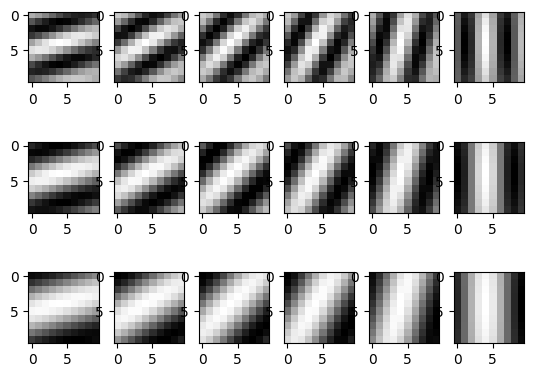

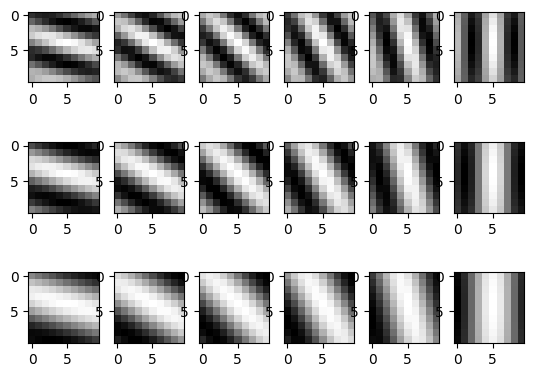

In [36]:
class Gabor():
    def __init__(self, R, C, n_orientation, scale, flip = False):
        self.R = R
        self.C = C
        self.n_orientation = n_orientation
        self.scale = scale
        self.orientation = np.array([ (u * np.pi / n_orientation) for u in range (1, n_orientation + 1)])
        self.gabor_filters_sets = [gabor_wavelet(R, C, u, scale, n_orientation, flip) for u in range(1, n_orientation + 1)]
        self.flip = flip            # flip filter for left hand
    

    # filter image through gabor filters
    def filtering(self, img):
        graphs = np.array([cv2.filter2D(img, -1, np.real(gw)) for gw in self.gabor_filters_sets])
        return graphs
    
    def plot_filters(self, n_scale):
        gabor_filters = []
        fig = plt.figure()
        for v in range (1, n_scale + 1):
            for u in range(1, self.n_orientation + 1):
                gw = gabor_wavelet(self.R, self.C, u, v , self.n_orientation, self.flip)
                fig.add_subplot(n_scale, self.n_orientation, self.n_orientation * (v- 1) + u)
                plt.imshow(np.real(gw), cmap='gray')
        plt.show()

    

def gabor_wavelet(rows, cols, orientation, scale, n_orientation, flip):
    kmax = np.pi / 2        # 1.5707963267948966
    f = np.sqrt(2)          # 1.4142135623730951 
    delt2 = (2 * np.pi) ** 2
    k = (kmax / (f ** scale)) * np.exp(1j * orientation * np.pi / n_orientation / 2)
    kn2 = np.abs(k) ** 2
    gw = np.zeros((rows, cols), np.complex128)

    for m in range(int(-rows / 2) + 1, int(rows / 2) + 1):
        for n in range(int(-cols / 2) + 1, int(cols / 2) + 1):
            t1 = np.exp(-0.5 * kn2 * (m ** 2 + n ** 2) / delt2)
            t2 = np.exp(1j * (np.real(k) * m + np.imag(k) * n))
            t3 = np.exp(-0.5 * delt2)
            gw[int(m + rows / 2 - 1), int(n + cols / 2 - 1)] = (kn2 / delt2) * t1 * (t2 - t3)


    if (flip == True):
        gw = np.fliplr(gw)

    return gw



# RGA (gabor filter for right hand)
n_orientation = 6
scale = 2
RGA = Gabor(10, 10, n_orientation, scale)
right_gabor_filters = RGA.gabor_filters_sets
RGA.plot_filters(3)

# LGA (gabor filter for right hand)
n_orientation = 6
scale = 2
LGA = Gabor(10, 10, n_orientation, scale, flip = True)
left_gabor_filters = LGA.gabor_filters_sets
LGA.plot_filters(3)



## Laplacian Filter

In [37]:
def Lo_pass_Gaussian_procwess(img, D0):
    rows, cols = img.shape
    mask = np.zeros((rows, cols))
    Locx = np.array(list(range(cols)) * rows).reshape([rows, cols])
    Locy = np.transpose((np.array(list(range(rows)) * cols).reshape([cols,rows])))
    D = np.sqrt((Locx - cols / 2) ** 2 + (Locy - rows / 2 ) ** 2)
    mask = np.exp(-D ** 2 / D0 ** 2 / 2)

    f1 = np.fft.fft2(img)
    f1shift = np.fft.fftshift(f1)
    f1shift = f1shift * mask
    f2shift = np.fft.ifftshift(f1shift)
    img_new = np.fft.ifft2(f2shift)
    img_new = np.abs(img_new)

    return img_new

def LOG_preprocess(img, R0 = 40 , ksize = 5):
    AfterGaussian = np.uint8(Lo_pass_Gaussian_procwess(img, R0))
    processed = cv2.Laplacian(AfterGaussian, -1, ksize=ksize)
    img = cv2.equalizeHist(img)             
    return processed

## Process the image to extract feature


In [38]:
def show_array_img(arr, process):
    plt.figure(figsize=(12, 8))  # Đặt kích thước cửa sổ
    for idx, element in enumerate(arr):
        plt.subplot(3, 6, idx + 1)  # Sắp xếp ảnh trên lưới 3x4 (hoặc thay đổi tuỳ số lượng ảnh)
        plt.imshow(element, cmap='gray')  # Hiển thị ảnh ở dạng grayscale
        plt.title(f"{process} {idx+1}")  # Thêm tiêu đề cho từng ảnh
        plt.axis('off')  # Tắt trục toạ độ

    plt.tight_layout()  # Căn chỉnh lưới để không bị chồng lấn
    plt.show()
    
def Gab(img,label ):

    # Laplacian process image with above function
    img = LOG_preprocess(img)

    # remove image border due to unpredicted noise 
    img = img[10:190, 10:190]   

    # Gabor    
    After_gabor = []
    if label == "r":
        # Gabor for right hand
        for i, gw in enumerate(right_gabor_filters):
            element =  cv2.filter2D(img, -1, np.real(gw))    
            After_gabor.append(element)
    elif label == "l":
        # Gabor for left hand
        for i, gw in enumerate(left_gabor_filters):
            element =  cv2.filter2D(img, -1, np.real(gw))    
            After_gabor.append(element)
            
    show_array_img(After_gabor, "Gabor")
    

    Two_value = []
    for i, line in enumerate(After_gabor):
        _, TW = cv2.threshold(line, 0 , 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        kernel = np.ones((2,2), np.uint8)
        TW = cv2.erode(TW, kernel)
        Two_value.append(TW)
    show_array_img(Two_value, "threshold")

    con = []
    for i in Two_value:
        conective = morphology.remove_small_objects(i > 0, min_size=40, connectivity=1)
        con.append(conective)
    show_array_img(con, "Remove small object")

    line = (np.sum(con, axis = 0) / len(con))
    
    return line 




# HOG

In [39]:
# HOG
    
# HOG với 9 hướng, cell có kích thước 10*10 
def Hog(edge_img):
    (H, hog_img) = feature.hog(edge_img, orientations=9, pixels_per_cell=(10, 10),
                cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)

    hogImage = exposure.rescale_intensity(hog_img, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")

   
    return H,hog_img

# RUN

## Data Folder Path

In [40]:
path = 'roi_test'


In [41]:
def process(path, label , visualize = True):
    

    img = plt.imread(path)
    

    img = cv2.resize(img, (200,200), interpolation=cv2.INTER_LINEAR)
    

    # đưa hình ảnh về dạng np.array để có thể sử dụng thư viện cv2
    
    ori_img = img                               # store image for visualize
    

    # apply gaussian smotthing
    log_img = LOG_preprocess(img)               # store image for visualize
    
    # apply gabor filter 
    edge_img = Gab(img,label)

    (H, hog_img) = Hog(edge_img)

    if (visualize):
        plt.figure(figsize=(16,4))
        plt.subplot(141)
        plt.imshow(ori_img,cmap='gray')
        plt.title('Region of interest')
        plt.axis('off')

        plt.subplot(142)
        plt.imshow(log_img, cmap='gray')
        plt.title("Laplacian of Gaussian")
        plt.axis('off')
        
        plt.subplot(143)
        plt.imshow(edge_img, cmap='gray')
        plt.axis('off')
        plt.title('Gabor filter')

        plt.subplot(144)
        plt.imshow(hog_img)
        plt.title("Histogram of oriented gradient")
        plt.axis('off')
    return H, edge_img
    
    




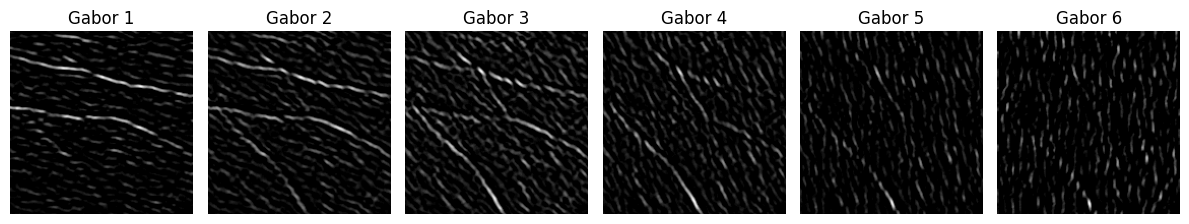

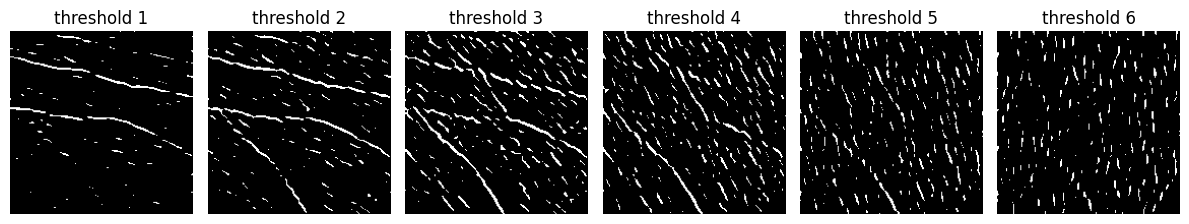

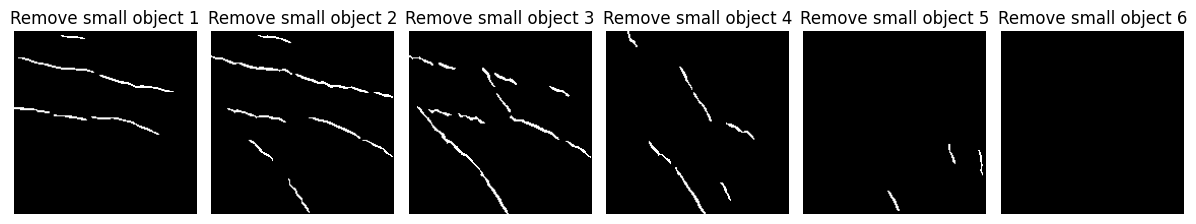

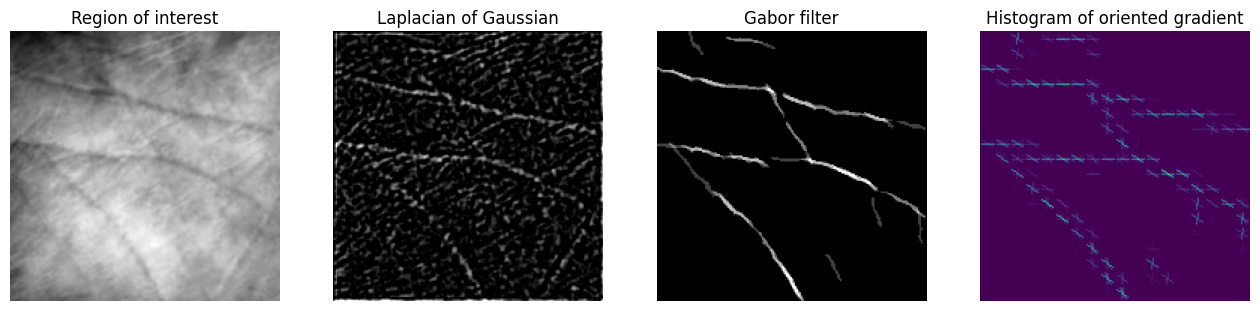

In [42]:
data = []


file_path='roi_test/0001/0001_m_l_01_roi.jpg'
file_name = file_path.split('/')[-1]

item_data = []
# extract label from file path
label = file_name.split('_')

item_data.append(label[0])      # people ex: 0001
item_data.append(label[1])      # gener ex: m
item_data.append(label[2])      # hand (left or right) ex: l

H, hog_img = process(file_path, label = label[2])

item_data.append(H)


